<h3 style="color:darkorange">1. Initialization</h3>

#### Import necessary libraries and set environment variables.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm  import tqdm
import tifffile
from unetext3Dn_con7s import UNet3D
import cellectP

<h3 style="color:darkorange">2. Load example images</h3>

#### Load and visualize sample TIFF images from specified paths.

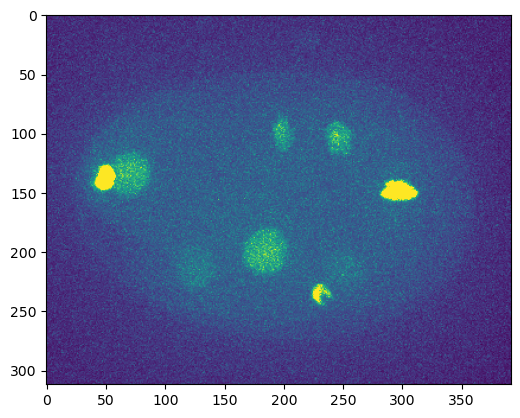

In [2]:
path='./example/'
img=tifffile.TiffFile(path+'mskcc_confocal_s2_t020.tif').asarray().transpose([1,2,0])[100:-100,60:-60]
img2=tifffile.TiffFile(path+'mskcc_confocal_s2_t021.tif').asarray().transpose([1,2,0])[100:-100,60:-60]
img3=tifffile.TiffFile(path+'mskcc_confocal_s2_t022.tif').asarray().transpose([1,2,0])[100:-100,60:-60]
plt.imshow(img.max(-1),vmax=3000)


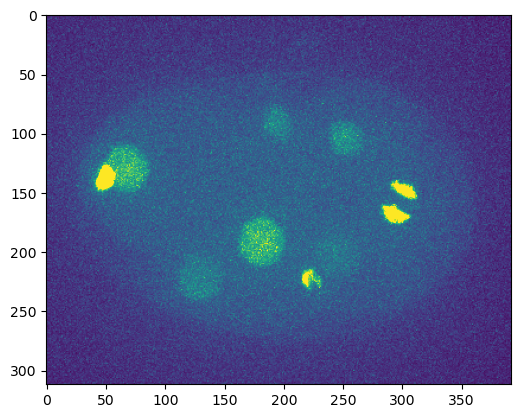

In [3]:
plt.imshow(img2.max(-1),vmax=3000)

<h3 style="color:darkorange">3. Load pre-trained models images</h3>

#### Set CUDA device, initialize UNet3D and EXNet models, set to eval and load pretrained weights.

In [4]:

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
U =UNet3D(2,6)
EX=cellectP.EXNet(64,8)
EN=cellectP.EXNet(64,6)
U.to(device)
EX.to(device)
EN.to(device)
U.eval()
EX.eval()
EN.eval()
if device == 'cpu':
    U.load_state_dict(torch.load('./model/U-ext+-x3rdstr0-149.0-3.4599.pth',map_location=torch.device('cpu')))
    EX.load_state_dict(torch.load('./model/EX+-x3rdstr0-149.0-3.4599.pth',map_location=torch.device('cpu')))
    EN.load_state_dict(torch.load('./model/EN+-x3rdstr0-149.0-3.4599.pth',map_location=torch.device('cpu'))) 
else:
    U.load_state_dict(torch.load('./model/U-ext+-x3rdstr0-149.0-3.4599.pth'))
    EX.load_state_dict(torch.load('./model/EX+-x3rdstr0-149.0-3.4599.pth'))
    EN.load_state_dict(torch.load('./model/EN+-x3rdstr0-149.0-3.4599.pth'))


<h3 style="color:darkorange">4. Setup preprocessing</h3>

Preprocess function PA shifts intensities based on data range [2000–65536].  
- Subtracts min, adds 1900 so minimum maps to 1900.  
- Applies log1p for compression.  
These adjustments can better match your training data, though the default (without shift) also often works well.

In [5]:
def PA(x):
    x=x-x.min()
    x+=1900
    x=torch.log1p(x)
    return x

Convert numpy images to torch tensors and check shape

In [6]:
img=torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
img2=torch.from_numpy(img2).unsqueeze(0).unsqueeze(0).to(device).float()
img3=torch.from_numpy(img3).unsqueeze(0).unsqueeze(0).to(device).float()
img.shape

torch.Size([1, 1, 312, 392, 41])

<h3 style="color:darkorange">5. Tracking</h3>

Run CELLECT tracking with frames, z-ratio, preprocessing, and models.
Inputs:
 - img, img2, img3: three consecutive frames
 - 5: z/xy resolution ratio
 - PA: preprocessing function
 - U, EX, EN: three trained models
 - div: enable divison
Outputs:
 - result: dict with keys for frame1/2 feature vectors and positions, inter-frame link results, and model scores.

In [7]:
result=cellectP.track(img, img2, img3, 5, PA, U, EX, EN, div=1 )
result.keys()

C:\Users\z\Downloads\CELLECT-main (5)\CELLECT-main\cellectP.py:303: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta = 1, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\python_arg_parser.cpp:1661.)
  distmat.addmm_(1, -2, px1.float(),px1.float().t())
C:\Users\z\Downloads\CELLECT-main (5)\CELLECT-main\cellectP.py:489: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c=F.softmax(sp)


dict_keys(['frame1', 'frame2', 'inter-score', 'link'])

<h3 style="color:darkorange">6. Visualization</h3>

In [8]:
result['frame1'].keys()

dict_keys(['intra-score', 'pos', 'feature', 'size', 'div', 'seg', 'seg_mask', 'group'])

In [9]:
result['frame1']['pos']

tensor([[100, 199, 130],
        [104, 250, 100],
        [134,  71,  95],
        [200, 185,  60],
        [212, 251, 145],
        [215, 127, 145],
        [137,  51, 170],
        [235, 230, 155],
        [149, 297, 100]], device='cuda:0')

In [10]:
result['frame1']['feature'].shape

torch.Size([9, 64])

Plot frame1 detected positions on img max-projection.

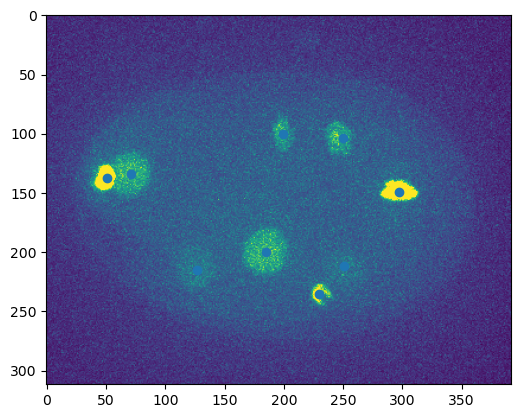

In [11]:
p1=result['frame1']['pos'].cpu()
plt.imshow(img.squeeze().cpu().max(-1)[0],vmax=3000)
plt.scatter(p1[:,1],p1[:,0])

Plot frame2 detected positions on img2 max-projection.

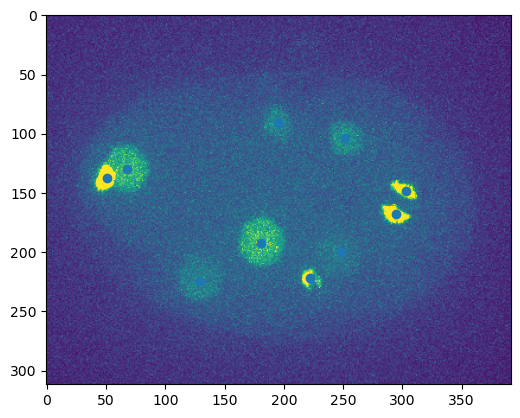

In [12]:
p1=result['frame2']['pos'].cpu()
plt.imshow(img2.squeeze().cpu().max(-1)[0],vmax=3000)
plt.scatter(p1[:,1],p1[:,0])

In [13]:
result['link']

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8, 9]}

Overlay frame1 (red) and frame2 (blue) detections on img max-projection.

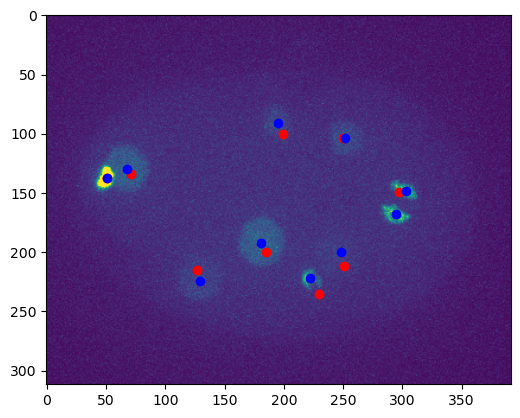

In [14]:
p1=result['frame1']['pos'].cpu()
p2=result['frame2']['pos'].cpu()
plt.imshow(img2.squeeze().cpu().max(-1)[0],vmax=4000)
plt.scatter(p1[:,1],p1[:,0],c='red')
plt.scatter(p2[:,1],p2[:,0],c='b')

Annotate tracking links with arrows from frame1 to frame2.

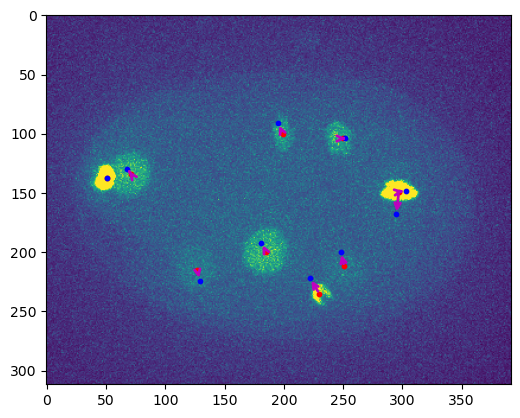

In [15]:
r=result['link']
p1=result['frame1']['pos'].cpu()
p2=result['frame2']['pos'].cpu()
plt.imshow(img.squeeze().cpu().max(-1)[0],vmax=3000)
plt.scatter(p1[:,1],p1[:,0],c='red',s=10)
plt.scatter(p2[:,1],p2[:,0],c='b',s=10)
for i in r:
    for j in r[i]:
        plt.annotate('', xy=(p2[j,1], p2[j,0]), xytext=(p1[i,1], p1[i,0]),
                     arrowprops=dict(arrowstyle='->', color='m', lw=2))


Display variable 'r' containing link results.

In [16]:
r

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8, 9]}

Visualize a simple instance segmentation result based on
coarse segmentation confidence map and size prediction.

This plots the max-projection over z of the predicted confidence-based
instance mask for a given frame.

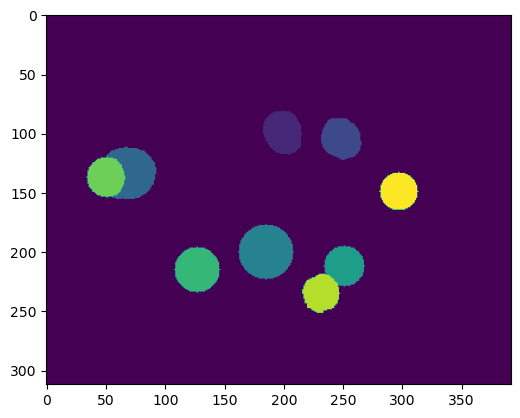

In [17]:
plt.imshow(result['frame1']['seg_mask'].max(-1))

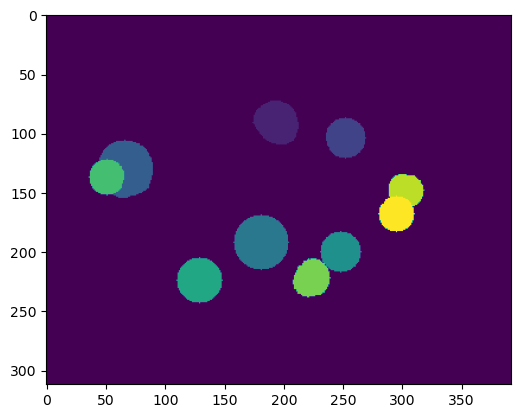

In [18]:
plt.imshow(result['frame2']['seg_mask'].max(-1))

Plot the binary segmentation mask (mask > 0) for a single frame.

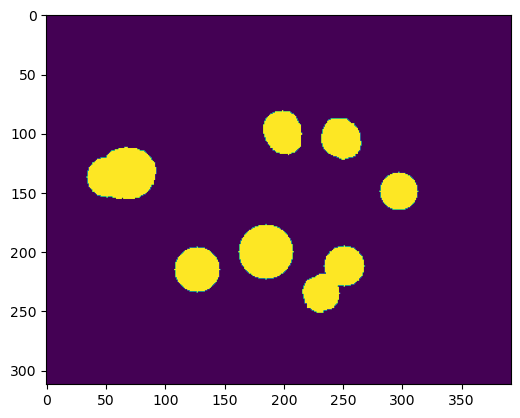

In [19]:
plt.imshow(result['frame1']['seg_mask'].max(-1)>0)